In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from utils import cut_bvp
from constants import Timestamps, expressive


In [17]:
base_path_video = "BVPs"

paths = [
    "Q1_1",
    "Q1_2",
    "Q2_1",
    "Q2_2",
    "Q3_1",
    "Q3_2",
    "Q4_1",
    "Q4_2",
    "Q5_1",
    "Q5_2",
    "Q6_1",
    "Q6_2",
    "Q7_1",
    "Q7_2",
    "Q8_1",
    "Q8_2",
    "Q9_1",
    "Q9_2"
]

# patients = list(range(1, 62))
# patients.remove(23)

patients = expressive

In [18]:
class BVP:
    def __init__(self, patient, path, signal, features):
        self.patient = patient
        self.path = path
        self.signal = signal
        self.features = features

In [19]:
fs = 60

BVPs = []

for patient in patients:

    for path in paths:

        data = np.load(f"{base_path_video}/Patient_{patient}/{path}.npy")

        bvp = BVP(patient, path, data, [])

        BVPs.append(bvp)

        #print(f"Patient_{patient}, {path}: {data.shape}")

print(f"Loaded {len(BVPs)} BVP signals")

Loaded 360 BVP signals


In [20]:
def get_peaks(bvp, fs):
    """
    Detect heart beats from BVP.
    distance ensures physiological HR range.
    """
    peaks, _ = find_peaks(
        bvp,
        distance=int(fs * 0.4)  # max 150 bpm
    )
    return peaks


In [21]:
def time_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    # RR intervals (seconds)
    rr = np.diff(peaks) / fs

    features = {}

    # Heart Rate
    features["HR_mean"] = 60 / np.mean(rr)
    features["HR_std"]  = np.std(60 / rr)

    # HRV features
    features["RMSSD"] = np.sqrt(np.mean(np.diff(rr) ** 2))
    features["SDNN"]  = np.std(rr)

    # pNN50
    features["pNN50"] = np.sum(np.abs(np.diff(rr)) > 0.05) / len(rr)

    return features


In [22]:
def frequency_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 4:
        return None

    rr = np.diff(peaks) / fs
    rr_times = np.cumsum(rr)

    # Interpolate RR series
    rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
    rr_interp = np.interp(rr_interp_time, rr_times, rr)

    freqs, psd = welch(rr_interp, fs=4.0)

    lf_band = (freqs >= 0.04) & (freqs < 0.15)
    hf_band = (freqs >= 0.15) & (freqs < 0.4)

    lf = np.trapezoid(psd[lf_band], freqs[lf_band])
    hf = np.trapezoid(psd[hf_band], freqs[hf_band])

    features = {
        "LF": lf,
        "HF": hf,
        "LF_HF": lf / hf if hf > 0 else 0
    }

    return features


In [23]:
def morphological_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    amplitudes = bvp[peaks]

    features = {
        "Pulse_amp_mean": np.mean(amplitudes),
        "Pulse_amp_std":  np.std(amplitudes)
    }

    return features


In [24]:
def extract_features_from_bvp(bvp, fs):
    feats = {}

    td = time_domain_features(bvp, fs)
    fd = frequency_domain_features(bvp, fs)
    md = morphological_features(bvp, fs)

    if td is None or fd is None or md is None:
        return None

    feats.update(td)
    feats.update(fd)
    feats.update(md)

    return feats


In [25]:
timestamp = getattr(Timestamps, BVPs[0].path)

print(timestamp)


[14, 22]


In [26]:
def cut_bvp2(bvp, t_start, t_end, fs = 60):

    n_start = int(t_start * fs)
    n_end   = int(t_end * fs) if t_end is not None else len(bvp)
    return bvp[n_start:n_end]


In [80]:
fs = 60

valid = []

failed = []

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

for bvp in BVPs:

    if [bvp.patient, bvp.path] in failed_masks:
        BVPs.remove(bvp)
        print(f"Skipping: Patient_{bvp.patient}, {bvp.path}")
        continue
    
    timestamp = getattr(Timestamps, bvp.path)

    t_start, t_end = timestamp[0], timestamp[-1]

    if t_start is None:
        print(f"Not Valid: Patient_{bvp.patient}, {bvp.path}")
        BVPs.remove(bvp)
        continue

    bvp_cut = cut_bvp2(bvp.signal, t_start, t_end)

    feats = extract_features_from_bvp(bvp_cut, fs)

    if feats is None:
        # Do nothing
        continue
    
    bvp.features = feats

    valid.append(f"Patient_{bvp.patient}, {bvp.path}")

print(f"Extracted features for {len(valid)} videos")


c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 11, using nperseg = 11
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 47, using nperseg = 47
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 17, using nperseg = 17
  freqs, _, Pxy = _spectral_helper

Extracted features for 278 videos


c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 22, using nperseg = 22
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  freqs, _, Pxy = _spectral_help

In [76]:
label_map = {
    "Q1": 2,
    "Q2": 2,
    "Q3": 2,
    "Q4": 1,
    "Q5": 1, 
    "Q6": 1,
    "Q7": 0,
    "Q8": 0,
    "Q9": 0
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [77]:
for bvp in BVPs:

    try: 

        for feat, val in bvp.features.items():
            #print(feat, val)
            i = 1
        #print(bvp.patient, bvp.path, "Success")

    except Exception as e:
        print(bvp.patient, bvp.path, e)


58 Q1_2 'list' object has no attribute 'items'


In [78]:
print(BVPs[0].features)

{'HR_mean': np.float64(86.65207877461705), 'HR_std': np.float64(29.007634305914003), 'RMSSD': np.float64(0.22852182001336813), 'SDNN': np.float64(0.16942619089084077), 'pNN50': np.float64(0.7272727272727273), 'LF': np.float64(0.0), 'HF': np.float64(0.0), 'LF_HF': 0, 'Pulse_amp_mean': np.float64(0.12982040257799346), 'Pulse_amp_std': np.float64(0.0851499197775386)}


In [84]:
for bvp in BVPs:
    if bvp.patient == 58 and bvp.path == "Q1_2":
        print(bvp.features)

None


In [82]:
for idx, bvp in enumerate(BVPs):
    print(idx, bvp.patient, bvp.path)

0 1 Q1_1
1 1 Q1_2
2 1 Q2_1
3 1 Q2_2
4 1 Q3_1
5 1 Q3_2
6 1 Q4_1
7 1 Q4_2
8 1 Q6_1
9 1 Q6_2
10 1 Q7_1
11 1 Q8_1
12 1 Q9_1
13 1 Q9_2
14 21 Q1_1
15 21 Q1_2
16 21 Q2_1
17 21 Q2_2
18 21 Q3_1
19 21 Q3_2
20 21 Q4_1
21 21 Q4_2
22 21 Q6_1
23 21 Q6_2
24 21 Q7_1
25 21 Q8_1
26 21 Q9_1
27 21 Q9_2
28 25 Q1_1
29 25 Q1_2
30 25 Q2_1
31 25 Q2_2
32 25 Q3_1
33 25 Q3_2
34 25 Q4_1
35 25 Q4_2
36 25 Q6_1
37 25 Q6_2
38 25 Q7_1
39 25 Q8_1
40 25 Q9_1
41 25 Q9_2
42 26 Q1_1
43 26 Q1_2
44 26 Q2_1
45 26 Q2_2
46 26 Q3_1
47 26 Q3_2
48 26 Q4_1
49 26 Q4_2
50 26 Q6_1
51 26 Q6_2
52 26 Q7_1
53 26 Q8_1
54 26 Q9_1
55 26 Q9_2
56 27 Q1_1
57 27 Q1_2
58 27 Q2_1
59 27 Q2_2
60 27 Q3_1
61 27 Q3_2
62 27 Q4_1
63 27 Q4_2
64 27 Q6_1
65 27 Q6_2
66 27 Q7_1
67 27 Q8_1
68 27 Q9_1
69 27 Q9_2
70 32 Q1_1
71 32 Q1_2
72 32 Q2_1
73 32 Q2_2
74 32 Q3_1
75 32 Q3_2
76 32 Q4_1
77 32 Q4_2
78 32 Q6_1
79 32 Q6_2
80 32 Q7_1
81 32 Q8_1
82 32 Q9_1
83 32 Q9_2
84 33 Q1_1
85 33 Q1_2
86 33 Q2_1
87 33 Q2_2
88 33 Q3_1
89 33 Q3_2
90 33 Q4_1
91 33 Q4_2
92 33 Q6_1
9

Q1_2
None


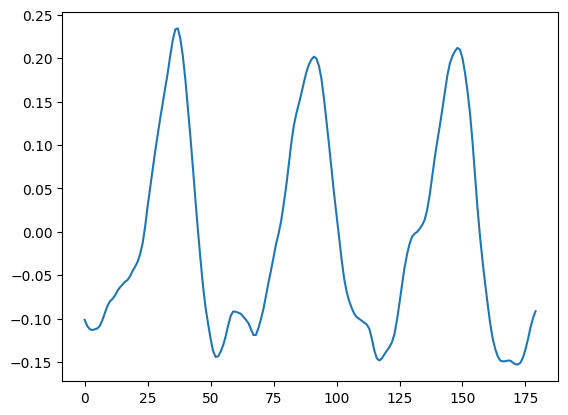

In [87]:
bvp = BVPs[252]

print(bvp.path)

timestamp = getattr(Timestamps, bvp.path)

t_start, t_end = timestamp[0], timestamp[-1]

bvp_cut = cut_bvp2(bvp.signal, t_start, t_end)

plt.plot(bvp_cut)

feats = extract_features_from_bvp(bvp_cut, fs)

print(feats)

bvp.features = feats

In [ ]:
import numpy as np

X = []
y = []

for bvp in BVPs:
    if bvp is None or bvp.features is None:
        continue

    feat_values = list(bvp.features.values())
    X.append(feat_values)
    y.append(get_label(bvp.path))

X = np.array(X)
y = np.array(y)


TypeError: list indices must be integers or slices, not str